In [25]:
!pip install flopco-pytorch

In [26]:
import torch
from torch import nn
import flopco
from flopco import FlopCo

from tqdm import tqdm as tqdm
import math
import time
import sys
import gc
import statistics

In [27]:
torch.random.manual_seed(10)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("cpu")
device_cpu = torch.device("cpu")
print(device)

cuda


In [28]:
l = torch.nn.Linear(10, 20)
for pname, p in l.named_parameters():
  print(pname, p.shape)

t = torch.randn((1, 20), dtype=torch.float16)
t.dtype

torch.finfo(torch.float16)

weight torch.Size([20, 10])
bias torch.Size([20])


finfo(resolution=0.001, min=-65504, max=65504, eps=0.000976562, smallest_normal=6.10352e-05, tiny=6.10352e-05, dtype=float16)

## Auxiliary functions

In [29]:
def print_mem_usage(layer):
  print('\t Shape')
  for name, tens in layer.named_parameters():
    print(name + ':\t', tuple(tens.shape))
  print()

  sum_bytes = 0
  sum_params = 0
  print('Parameters:')
  print('\tElems\t Bits\t\tBytes\t Kb\t\t Mb')
  for name, tens in layer.named_parameters():
    if tens.dtype is torch.float32:
      bytes_in_dtype = 4
    elif tens.dtype is torch.float64:
      bytes_in_dtype = 8
    else:
      print(name + " has unsupported type")
      continue
    elems = tens.numel()
    sum_params += elems
    sum_bytes += elems * bytes_in_dtype

    print(name + ':\t',
          elems, '\t', elems * bytes_in_dtype * 8,
          '\t', elems * bytes_in_dtype,
          '\t', elems * bytes_in_dtype / 1024,
          '\t', round(elems * bytes_in_dtype / 1024 / 1024, 5))
  print()
  print('Buffers:')
  print('\tElems\t Bits\t\tBytes\t Kb\t\t Mb')
  for name, tens in layer.named_buffers():
    if tens.dtype is torch.float32:
      bytes_in_dtype = 4
    elif tens.dtype is torch.float64:
      bytes_in_dtype = 8
    else:
      print(name + " has unsupported type")
      continue
    elems = tens.numel()
    sum_params += elems
    sum_bytes += elems * bytes_in_dtype

    print(name + ':\t',
          elems, '\t', elems * bytes_in_dtype * 8,
          '\t', elems * bytes_in_dtype,
          '\t', elems * bytes_in_dtype / 1024,
          '\t', round(elems * bytes_in_dtype / 1024 / 1024, 5))
  print()
  print('All:\t',
          sum_params, '\t', sum_bytes * 8,
          '\t', sum_bytes,
          '\t', sum_bytes / 1024,
          '\t', round(sum_bytes / 1024 / 1024, 5))


def gpu_mem_usage():
    gc.collect()

    if hasattr(torch.cuda, "reset_peak_memory_stats"):  # pytorch 1.4+
        torch.cuda.reset_peak_memory_stats()

    ma = torch.cuda.memory_allocated() / (1024 * 1024)
    max_ma = torch.cuda.max_memory_allocated() / (1024 * 1024)
    ca = torch.cuda.memory_reserved() / (1024 * 1024)
    max_ca = torch.cuda.max_memory_reserved() / (1024 * 1024)


    print(
        f"MA {round(ma, 4)} MB \
        Max_MA {round(max_ma, 4)} MB \
        CA {round(ca, 4)} MB \
        Max_CA {round(max_ca, 4)} MB "
        )
    if hasattr(torch.cuda, "reset_peak_memory_stats"):  # pytorch 1.4+
        torch.cuda.reset_peak_memory_stats()

    return (ma, max_ma, ca, max_ca)

## Custom Linear layer

In [30]:
class CustomLinear(nn.Module):
    """
    A module which applies a linear transformation
    A common name is fully-connected layer, InnerProductLayer in caffe.

    The module should work with 2D input of shape (n_samples, n_feature).
    """
    def __init__(self, n_in, n_out, dtype=torch.float32, device=None):
        super().__init__()
        if device is None:
          device = torch.device("cpu")
        self.W = nn.Parameter(torch.Tensor(n_out, n_in).type(dtype).to(device))
        self.b = nn.Parameter(torch.Tensor(n_out).type(dtype).to(device))

        # This is a nice initialization
        stdv = 1./math.sqrt(n_in)
        nn.init.uniform_(self.W, -stdv, stdv)
        nn.init.uniform_(self.b, -stdv, stdv)

    def forward(self, input):
        self.output = torch.add(torch.mm(input, self.W.T), self.b)

        return self.output

In [31]:
in_ch, out_ch = 100, 200 # example numbers

In [32]:
custom_linear_tf32 = CustomLinear(in_ch, out_ch, dtype=torch.float32, device=device_cpu)
print('Theoretical memory usage of linear layer in float32')
print_mem_usage(custom_linear_tf32)

Theoretical memory usage of linear layer in float32
	 Shape
W:	 (200, 100)
b:	 (200,)

Parameters:
	Elems	 Bits		Bytes	 Kb		 Mb
W:	 20000 	 640000 	 80000 	 78.125 	 0.07629
b:	 200 	 6400 	 800 	 0.78125 	 0.00076

Buffers:
	Elems	 Bits		Bytes	 Kb		 Mb

All:	 20200 	 646400 	 80800 	 78.90625 	 0.07706


In [33]:
custom_linear_tf64 = CustomLinear(in_ch, out_ch, dtype=torch.float64, device=device_cpu)
print('Theoretical memory usage of linear layer in float64')
print_mem_usage(custom_linear_tf64)

Theoretical memory usage of linear layer in float64
	 Shape
W:	 (200, 100)
b:	 (200,)

Parameters:
	Elems	 Bits		Bytes	 Kb		 Mb
W:	 20000 	 1280000 	 160000 	 156.25 	 0.15259
b:	 200 	 12800 	 1600 	 1.5625 	 0.00153

Buffers:
	Elems	 Bits		Bytes	 Kb		 Mb

All:	 20200 	 1292800 	 161600 	 157.8125 	 0.15411


In [34]:
in_channel, out_channel = in_ch, out_ch
custom_linear = CustomLinear(in_channel, out_channel, device=device)

print("Theoretical memory usage")
print_mem_usage(custom_linear)
print()
print("Practical memory usage")
gpu_mem_usage()

Theoretical memory usage
	 Shape
W:	 (200, 100)
b:	 (200,)

Parameters:
	Elems	 Bits		Bytes	 Kb		 Mb
W:	 20000 	 640000 	 80000 	 78.125 	 0.07629
b:	 200 	 6400 	 800 	 0.78125 	 0.00076

Buffers:
	Elems	 Bits		Bytes	 Kb		 Mb

All:	 20200 	 646400 	 80800 	 78.90625 	 0.07706

Practical memory usage
MA 0.1553 MB         Max_MA 0.1553 MB         CA 2.0 MB         Max_CA 2.0 MB 


(0.1552734375, 0.1552734375, 2.0, 2.0)

In [35]:

# (custom_linear.weight.numel()*4 + custom_linear.bias.numel()*4)/1024/1024

In [36]:
inp = torch.randn(1,in_channel).to(device)

torch_linear = nn.Linear(in_channel, out_channel).to(device)
torch_linear.weight = custom_linear.W
torch_linear.bias = custom_linear.b

torch.linalg.norm(custom_linear(inp) - torch_linear(inp)).item()

0.0

## Custom Conv2d layer

In [37]:
class CustomConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 dtype=torch.float32, device=None):
        super().__init__()
        if device is None:
          device = torch.device("cpu")

        self.kernel_size = kernel_size
        if isinstance(kernel_size, int):
            self.kernel_size = (kernel_size, kernel_size)
        self.out_channels = out_channels
        self.in_channels = in_channels
        self.conv = nn.Parameter(torch.Tensor(self.out_channels, self.in_channels, *self.kernel_size).type(dtype).to(device))
        self.b = nn.Parameter(torch.Tensor(self.out_channels).type(dtype).to(device))

        # This is a nice initialization
        stdv = 1./math.sqrt(self.in_channels)
        nn.init.uniform_(self.conv, -stdv, stdv)
        nn.init.uniform_(self.b, -stdv, stdv)

    def forward(self, x):
        return nn.functional.conv2d(x, self.conv, self.b)

In [38]:
in_channel, out_channel = 5, 10
h, w = 300, 300
kernel_size = 3
inp = torch.randn(1, in_channel, h, w).to(device)
custom_conv = CustomConv2d(in_channel, out_channel, kernel_size, device=device)

In [39]:
torch_conv = nn.Conv2d(in_channel, out_channel, kernel_size).to(device)
torch_conv.weight = custom_conv.conv
torch_conv.bias = custom_conv.b

In [40]:
torch.linalg.norm(custom_conv(inp) - torch_conv(inp))

tensor(0., device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)

In [41]:
print_mem_usage(custom_conv)
print()
print_mem_usage(torch_conv)

	 Shape
conv:	 (10, 5, 3, 3)
b:	 (10,)

Parameters:
	Elems	 Bits		Bytes	 Kb		 Mb
conv:	 450 	 14400 	 1800 	 1.7578125 	 0.00172
b:	 10 	 320 	 40 	 0.0390625 	 4e-05

Buffers:
	Elems	 Bits		Bytes	 Kb		 Mb

All:	 460 	 14720 	 1840 	 1.796875 	 0.00175

	 Shape
weight:	 (10, 5, 3, 3)
bias:	 (10,)

Parameters:
	Elems	 Bits		Bytes	 Kb		 Mb
weight:	 450 	 14400 	 1800 	 1.7578125 	 0.00172
bias:	 10 	 320 	 40 	 0.0390625 	 4e-05

Buffers:
	Elems	 Bits		Bytes	 Kb		 Mb

All:	 460 	 14720 	 1840 	 1.796875 	 0.00175


In [42]:
nn.Conv2d?

Init signature:
nn.Conv2d(
    in_channels: int,
    out_channels: int,
    kernel_size: Union[int, Tuple[int, int]],
    stride: Union[int, Tuple[int, int]] = 1,
    padding: Union[str, int, Tuple[int, int]] = 0,
    dilation: Union[int, Tuple[int, int]] = 1,
    groups: int = 1,
    bias: bool = True,
    padding_mode: str = 'zeros',
    device=None,
    dtype=None,
) -> None
Docstring:     
Applies a 2D convolution over an input signal composed of several input
planes.

In the simplest case, the output value of the layer with input size
:math:`(N, C_{\text{in}}, H, W)` and output :math:`(N, C_{\text{out}}, H_{\text{out}}, W_{\text{out}})`
can be precisely described as:

.. math::
    \text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
    \sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)


where :math:`\star` is the valid 2D `cross-correlation`_ operator,
:math:`N` is a batch size, :math:`C` denotes a number of channels,
:

# FLOP and Time estimation and dependence on input size

In [43]:
in_channel, out_channel = 3, 21
h, w = 300, 300
kernel_size = 3

In [44]:
torch_conv = nn.Conv2d(in_channel, out_channel, kernel_size).to(device_cpu)
stats = FlopCo(torch_conv,
               img_size = (1, in_channel, h, w),
               device = device_cpu,
               instances = [nn.Conv2d])

print("MFlop:\t", stats.flops[''][0]/10e6)
print("Parameters:\t", stats.params[''])

MFlop:	 10.256862
Parameters:	 588


In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

## Linear Flop estimation

In [46]:
flops = []
for in_chan in range(200,4000,200):
  torch_linear = nn.Linear(in_chan, 1000).to(device_cpu)
  stats = FlopCo(torch_linear,
                img_size = (1, in_chan),
                device = device_cpu,
                instances = [nn.Linear])
  flops.append(stats.flops[''][0]/10e6)

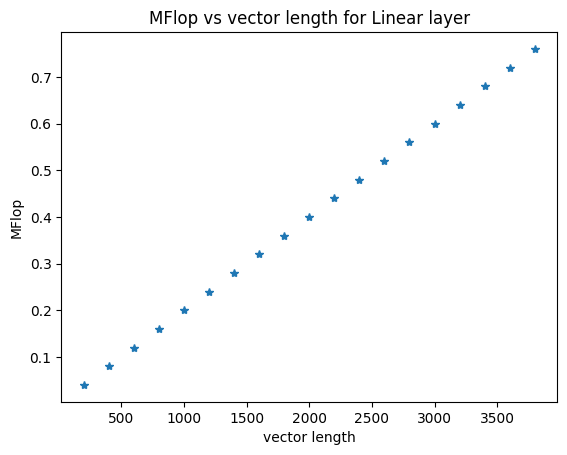

In [47]:
import matplotlib.pylab as plt

plt.plot(list(range(200,4000,200)), flops, '*')
plt.xlabel('vector length')
plt.ylabel('MFlop')
plt.title('MFlop vs vector length for Linear layer')
plt.show()

## Convd2d Flop estimation

In [48]:
torch_conv = nn.Conv2d(in_channel, out_channel, kernel_size).to(device_cpu)
flops = []
for h in tqdm(range(100,2000,100)):
  stats = FlopCo(torch_conv,
                img_size = (1, in_channel, h, h),
                device = device_cpu,
                instances = [nn.Conv2d])
  flops.append(stats.flops[''][0]/10e6)

100%|██████████| 19/19 [00:01<00:00,  9.85it/s]


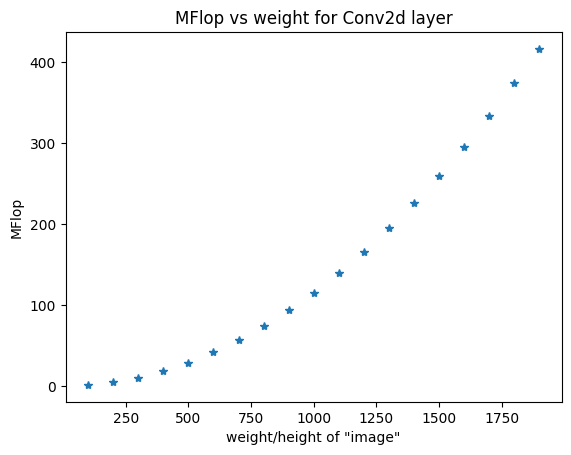

In [49]:
plt.plot(list(range(100,2000,100)), flops, '*')
plt.xlabel('weight/height of "image"')
plt.ylabel('MFlop')
plt.title('MFlop vs weight for Conv2d layer')
plt.show()

## Convd2d time estimation

In [50]:
torch_conv = nn.Conv2d(in_channel, out_channel, kernel_size).to(device_cpu)
time_empir = []
warmups = 5
repeat = 45
for h in tqdm(range(100,2000,100)):
  time_h = []
  input = torch.randn(1, in_channel, h, h).to(device_cpu)
  for _ in range(warmups):
    tmp = torch_conv(input)
  for _ in range(repeat):
    start = time.time()
    tmp = torch_conv(input)
    end = time.time()
    time_h.append(end-start)
  time_empir.append(statistics.mean(time_h))

100%|██████████| 19/19 [00:53<00:00,  2.81s/it]


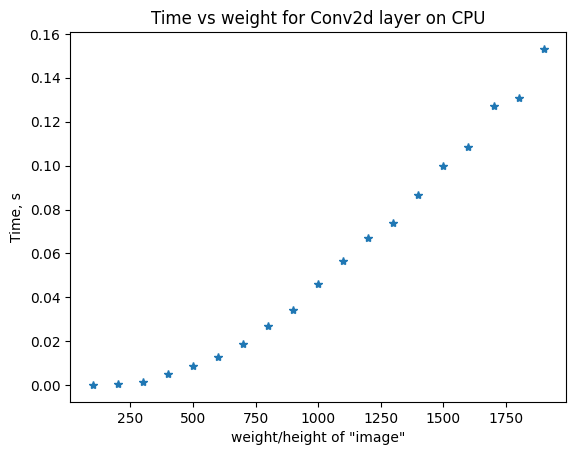

In [51]:
plt.plot(list(range(100,2000,100)), time_empir, '*')
plt.xlabel('weight/height of "image"')
plt.ylabel('Time, s')
plt.title('Time vs weight for Conv2d layer on CPU')
plt.show()

In [52]:
torch_conv = nn.Conv2d(in_channel, out_channel, kernel_size).to(device)
time_empir = []
warmups = 5
repeat = 30
for h in tqdm(range(100,2000,100)):
  time_h = []
  input = torch.randn(10, in_channel, h, h).to(device)
  for _ in range(warmups):
    tmp = torch_conv(input)
  for _ in range(repeat):
    start = time.time()
    tmp = torch_conv(input)
    torch.cuda.synchronize()
    end = time.time()
    time_h.append(end-start)
  time_empir.append(statistics.mean(time_h))

100%|██████████| 19/19 [00:14<00:00,  1.34it/s]


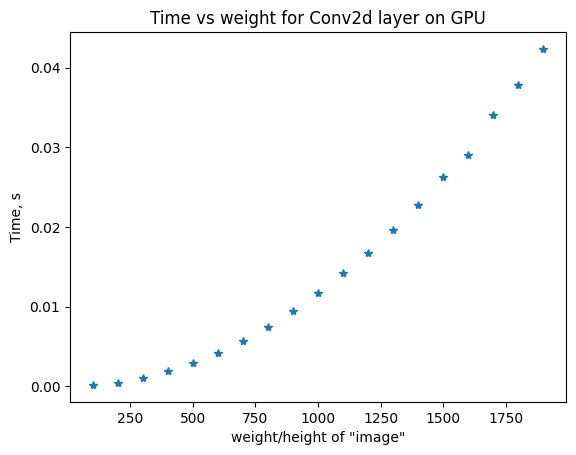

In [53]:
plt.plot(list(range(100,2000,100)), time_empir, '*')
plt.xlabel('weight/height of "image"')
plt.ylabel('Time, s')
plt.title('Time vs weight for Conv2d layer on GPU')
plt.show()

## ReLU time estimation

In [54]:
torch_relu = nn.ReLU().to(device_cpu)
time_empir = []
vector_len = []
warmups = 5
repeat = 150
for h in tqdm(range(100,2000,100)):
  time_h = []
  input = torch.randn(1, h*10000).to(device_cpu)
  for _ in range(warmups):
    tmp = torch_relu(input)
  for _ in range(repeat):
    start = time.time()
    tmp = torch_relu(input)
    end = time.time()
    time_h.append(end-start)
  time_empir.append(statistics.mean(time_h))
  vector_len.append(input.numel())

100%|██████████| 19/19 [00:20<00:00,  1.06s/it]


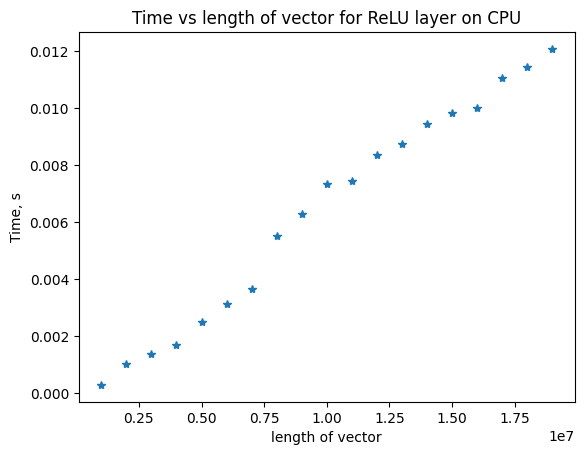

In [55]:
plt.plot(vector_len, time_empir, '*')
plt.xlabel('length of vector')
plt.ylabel('Time, s')
plt.title('Time vs length of vector for ReLU layer on CPU')
plt.show()

## Custom BatchNorm2d layer

In [56]:
class CustomBatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super().__init__()

        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.register_buffer('running_mean', torch.zeros(num_features))
        self.register_buffer('running_var', torch.ones(num_features))

    def forward(self, input):
        momentum = self.momentum

        # calculate running estimates
        if self.training:
            mean = input.mean([0, 2, 3])
            # use biased var in train
            var = input.var([0, 2, 3], unbiased=False)
            n = input.numel() / input.size(1)
            with torch.no_grad():
                self.running_mean = momentum * mean \
                                + (1 - momentum) * self.running_mean
                # update running_var with unbiased var
                self.running_var = momentum * var * n / (n - 1) \
                                + (1 - momentum) * self.running_var
        else:
            mean = self.running_mean
            var = self.running_var

        input = (input - mean[None, :, None, None]) / (torch.sqrt(var[None, :, None, None] + self.eps))

        return input

In [57]:
n_channels = 100
custom_bn = CustomBatchNorm2d(n_channels)
torch_bn = nn.BatchNorm2d(n_channels, affine=False)

inp = torch.randn(20, n_channels, 25, 25, dtype=torch.float32)

In [58]:
torch.linalg.norm(custom_bn(inp) - torch_bn(inp))

tensor(6.6959e-05)

In [59]:
print_mem_usage(custom_bn)
print()
print_mem_usage(torch_bn)

	 Shape

Parameters:
	Elems	 Bits		Bytes	 Kb		 Mb

Buffers:
	Elems	 Bits		Bytes	 Kb		 Mb
running_mean:	 100 	 3200 	 400 	 0.390625 	 0.00038
running_var:	 100 	 3200 	 400 	 0.390625 	 0.00038

All:	 200 	 6400 	 800 	 0.78125 	 0.00076

	 Shape

Parameters:
	Elems	 Bits		Bytes	 Kb		 Mb

Buffers:
	Elems	 Bits		Bytes	 Kb		 Mb
running_mean:	 100 	 3200 	 400 	 0.390625 	 0.00038
running_var:	 100 	 3200 	 400 	 0.390625 	 0.00038
num_batches_tracked has unsupported type

All:	 200 	 6400 	 800 	 0.78125 	 0.00076


## Linear+ReLU flops and time estimation

In [60]:

time_empir = []
flops = []
all_stats = []
warmups = 5
repeat = 45
for in_chan in range(200,4000,200):
  time_h = []
  torch_linear = nn.Linear(in_chan, 1000).to(device_cpu)
  relu = nn.ReLU()
  tiny_model = nn.Sequential(torch_linear, relu)
  input = torch.randn(1, in_chan).to(device_cpu)

  for _ in range(warmups):
    tmp = tiny_model(input)
  for _ in range(repeat):
    start = time.time()
    tmp = tiny_model(input)
    end = time.time()
    time_h.append(end-start)
  time_empir.append(statistics.mean(time_h))

  stats = FlopCo(tiny_model,
                img_size = (1, in_chan),
                device = device_cpu,
                instances = [nn.Linear, nn.ReLU])
  flops.append(stats.total_flops/10e6)
  all_stats.append(stats)


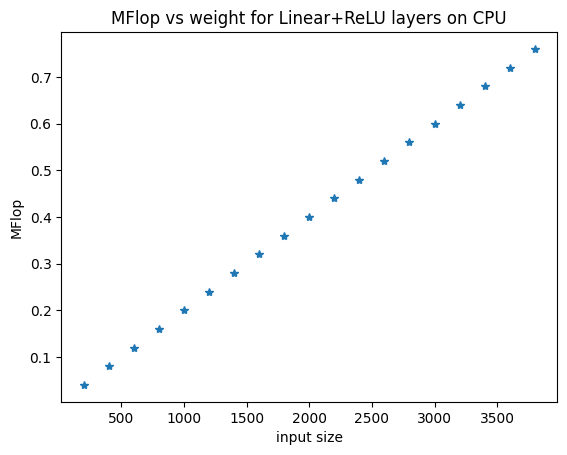

In [61]:
plt.plot(list(range(200,4000,200)), flops, '*')
plt.xlabel('input size')
plt.ylabel('MFlop')
plt.title('MFlop vs weight for Linear+ReLU layers on CPU')
plt.show()

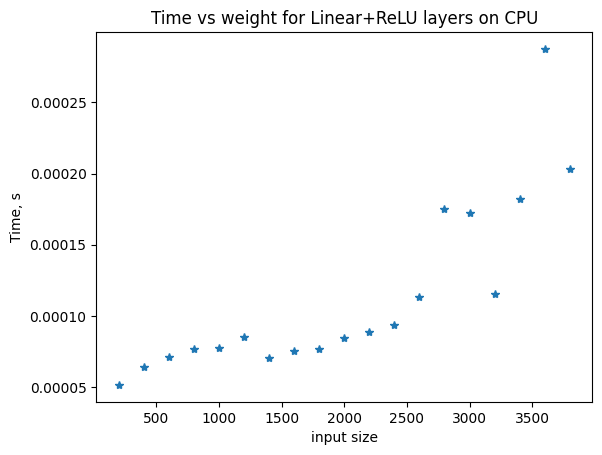

In [62]:
plt.plot(list(range(200,4000,200)), time_empir, '*')
plt.xlabel('input size')
plt.ylabel('Time, s')
plt.title('Time vs weight for Linear+ReLU layers on CPU')
plt.show()

## Conv2d+BN+ReLU flops and time estimation

In [63]:
in_channel, out_channel = 3, 21
h, w = 300, 300
kernel_size = 3

time_empir = []
flops = []
all_stats = []
warmups = 5
repeat = 25
for h in tqdm(range(100,2000,100)):
  time_h = []
  torch_conv = nn.Conv2d(in_channel, out_channel, kernel_size).to(device_cpu)
  torch_bn = nn.BatchNorm2d(out_channel)
  relu = nn.ReLU()
  tiny_model = nn.Sequential(torch_conv, torch_bn, relu)
  input = torch.randn(1, in_channel, h, h).to(device_cpu)

  for _ in range(warmups):
    tmp = tiny_model(input)
  for _ in range(repeat):
    start = time.time()
    tmp = tiny_model(input)
    end = time.time()
    time_h.append(end-start)
  time_empir.append(statistics.mean(time_h))

  stats = FlopCo(tiny_model,
                img_size = input.shape,
                device = device_cpu,
                instances = [nn.Conv2d, nn.BatchNorm2d, nn.ReLU])
  flops.append(stats.total_flops/10e6)
  all_stats.append(stats)



100%|██████████| 19/19 [01:01<00:00,  3.21s/it]


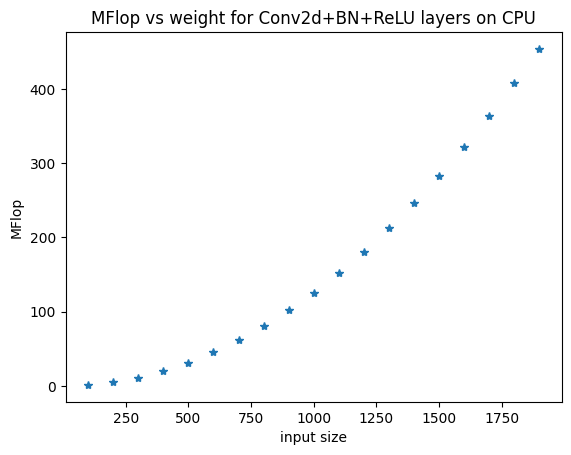

In [64]:
plt.plot(list(range(100,2000,100)), flops, '*')
plt.xlabel('input size')
plt.ylabel('MFlop')
plt.title('MFlop vs weight for Conv2d+BN+ReLU layers on CPU')
plt.show()

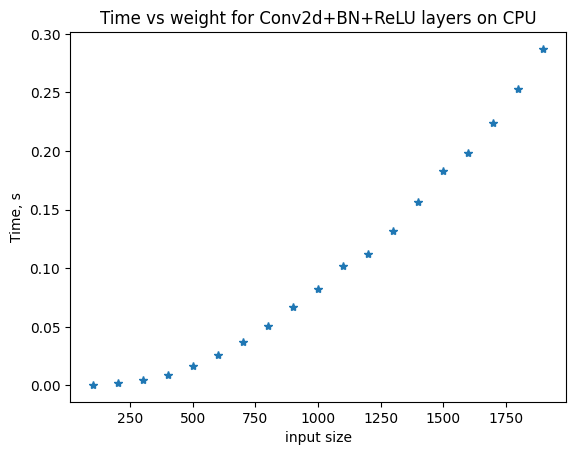

In [65]:
plt.plot(list(range(100,2000,100)), time_empir, '*')
plt.xlabel('input size')
plt.ylabel('Time, s')
plt.title('Time vs weight for Conv2d+BN+ReLU layers on CPU')
plt.show()